In [16]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

np.random.seed(42)


df = pd.read_csv('data/binance/BTCUSDT_1m_Futures.csv', index_col=0, parse_dates=True)
data = df[['Open', 'High', 'Low', 'Close', 'Volume']][-1000:]


data



,Open,High,Low,Close,Volume
Date,,,,,
2024-07-01 22:02:00,63033.9,63043.2,63028.9,63043.2,32.716
2024-07-01 22:03:00,63043.1,63047.2,63002.4,63015.4,57.031
2024-07-01 22:04:00,63015.3,63040.4,63015.3,63040.3,22.059
2024-07-01 22:05:00,63040.3,63043.4,63023.4,63034.4,38.873
2024-07-01 22:06:00,63034.9,63054.5,63034.7,63034.7,36.298
...,...,...,...,...,...
2024-07-02 14:37:00,62093.7,62093.7,62080.0,62093.0,39.111
2024-07-02 14:38:00,62092.9,62122.9,62086.6,62117.6,90.510
2024-07-02 14:39:00,62117.6,62142.0,62111.0,62142.0,63.159


<Axes: xlabel='Date'>

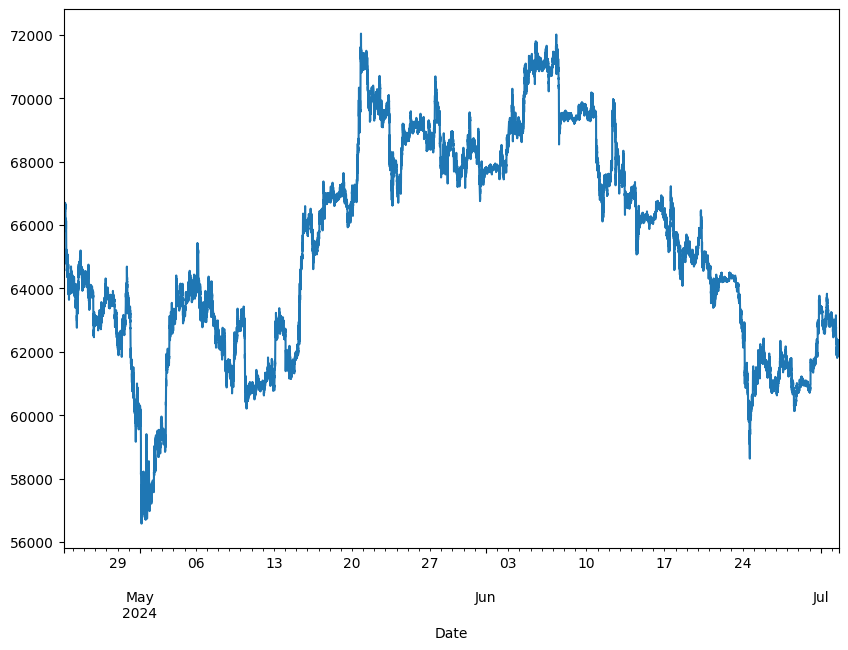

In [2]:
data['Close'].plot(figsize=(10, 7))

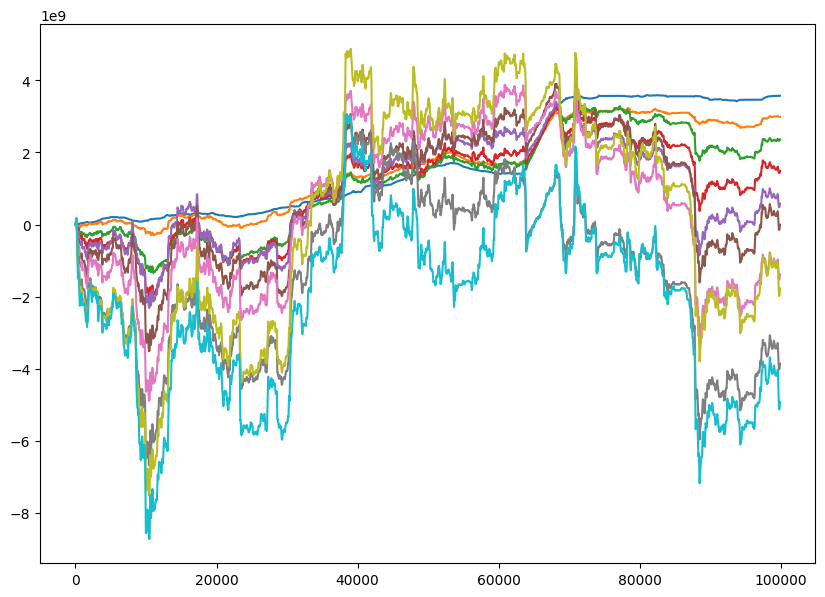

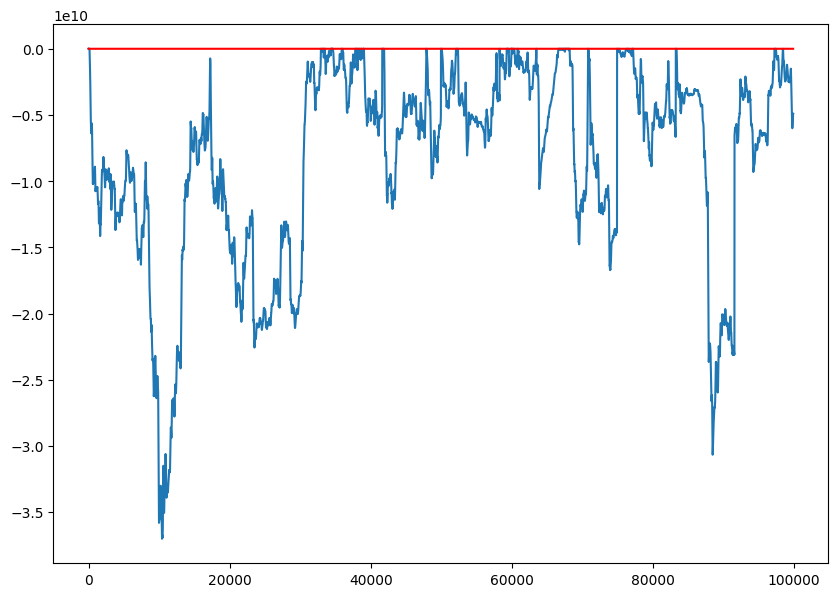

ValueError: weights should have the same shape as x

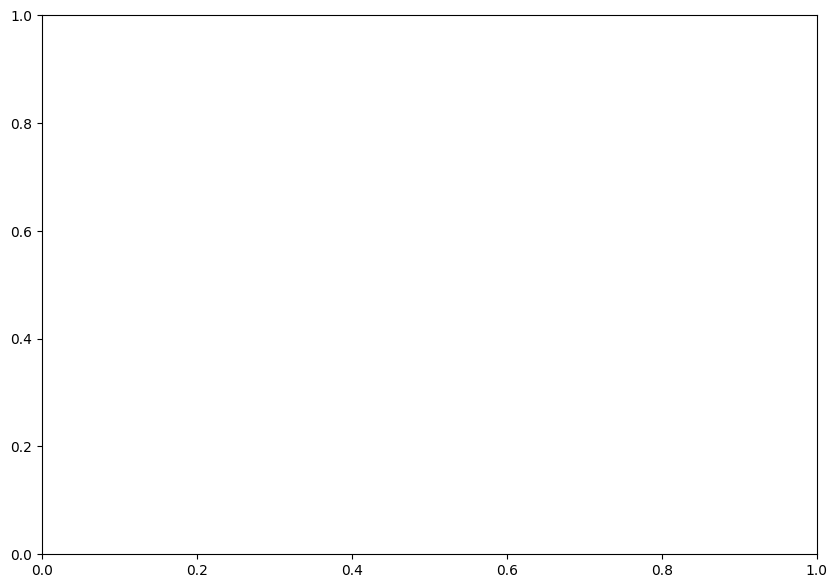

In [15]:
from numba import jit, njit, prange, vectorize, float64, int64, cuda, float32, guvectorize, void
from numba import float32, int32, int64, void, float64
from numba.typed import List
from numba.types import UniTuple

import numba as nb


nb_float = float64
nb_int = int64



class Backtest:
    def __init__(self, data, ma_lenth=100, num_grid=100, fee=-0.00015, pyrimading=1):
        
        self.fee = fee
        self.pyramiding = np.ones(pyrimading, dtype=np.int64)/pyrimading
        
        self.num_grid = num_grid
    
        self.data = data
        
        self.decimal = len(str(data.iloc[0]['Close']).split('.')[1]) if '.' in str(data.iloc[0]['Close']) else 0
        
        self.data.loc[:, 'SMA'] = self.data['Close'].rolling(window=ma_lenth).mean().round(self.decimal)
        
        self.max_diff = ((self.data['SMA']-self.data['Close'])/self.data['SMA']).abs().max()
        
        stop_idx = self.data[(self.data['SMA'] < self.data['High']) & (self.data['SMA'] > self.data['Low'])].index[-1]

        self.data = self.data[:stop_idx].dropna()
        
        id = np.concatenate([np.arange(-self.num_grid, 0, 1, dtype=int), np.arange(1, self.num_grid+1, dtype=int)])
        
        self.orders = {
            'id': id,
            'open_price': -id * self.max_diff/self.num_grid,
            'close_price': np.zeros(self.num_grid*2),
            'amount': np.sign(id),
            }

        self.orders = pd.DataFrame(self.orders)
        
        
        
    @staticmethod
    # @njit([UniTuple(nb_float[:, :], 2)(nb_float[:, :], nb_float[:, :], nb_float, nb_float[:])], parallel=True, fastmath=True)
    @njit(parallel=True, fastmath=True)
    def run_jit(data, orders,  fee, pyramiding):

        num_positions = np.zeros(len(orders), dtype=np.float64  )
        
        portfolio = np.zeros((len(data), len(orders), len(pyramiding)), dtype=np.float64)
        usdt_returns = np.zeros((len(data), len(orders), len(pyramiding)), dtype=np.float64)
        
        # pos = np.zeros((len(data), len(orders), len(pyramiding)), dtype=np.float64)
        
            
        for j in prange(len(orders)):
            
            id, open_on, close_on, amount = orders[j]
            
            opened_price = np.full(len(pyramiding), -1., dtype=np.float64)
            
            # opened_price = -1
            sum_positions = np.zeros(len(pyramiding), dtype=np.float64)
            
            normal_qty = 1 - fee

            for i in range(len(data)):
                open, high, low, close, volume, sma = data[i]
                open_price = (open_on +1 ) * sma
                close_price = (close_on +1 ) * sma
                
                to_open = True

                for k in range(len(opened_price)):
                    
                    if to_open:
                        if opened_price[k] < 0:
                            
                            to_open = False

                            if amount > 0:
                                if low < open_price and open > open_price:
                                    opened_price[k] = open_price
                                    usdt_returns[i, j, k] -= normal_qty 
                                    num_positions[j] += 1
                                    # pos[i, j, k] = open_price
                            else:
                                if high > open_price and open < open_price:
                                    opened_price[k] = open_price
                                    usdt_returns[i, j] += normal_qty 
                                    num_positions[j] += 1
                                    # pos[i, j, k] = open_price
                                    
                        else:
                            if amount > 0:
                                if high > close_price and open < close_price:
                                    usdt_returns[i, j, k] += normal_qty /opened_price[k]*close_price
                                    opened_price[k] = -1.
                            else:    
                                if low < close_price and open > close_price:
                                    usdt_returns[i, j, k] -= normal_qty/opened_price[k]*close_price
                                    opened_price[k] = -1.
                        
                sum_positions += usdt_returns[i,j]
                port = sum_positions
                
                for k in range(len(opened_price)):
                    if opened_price[k] > 0:
                        port += 1/opened_price * close * amount 
                    
                portfolio[i,j] = port

            
            for k in range(len(opened_price)):
                if opened_price[k] > 0:
                    usdt_returns[i,j] += 1/opened_price * close * amount
                        
        return usdt_returns, portfolio, 0

    def run(self):
        
        # positions = self.run_jit(self.data.to_numpy(), self.orders.to_numpy())

        # self.positions = positions
        self.usdt_returns, self.portfolio, self.pos = self.run_jit(self.data.to_numpy(), self.orders.to_numpy(), self.fee, self.pyramiding)
        self.drawdown = self.cummax_diff(self.portfolio.sum(axis=1).sum(axis=1))
        
    
    def calc_amount(self):
        
        amount = np.ones((self.num_grid*2, len(self.pyramiding)), dtype=np.float64)
        
        self.usdt_returns = self.usdt_returns * amount
        self.portfolio = self.portfolio * amount
        # self.drawdown = self.cummax_diff(self.portfolio.sum(axis=1).sum(axis=1))
        
    # @staticmethod
    # @guvectorize([(float64[:], float64[:])], '(n)->(n)', target='cpu', nopython=True)
    # def cummax_diff(A, B):
    #     max_val = A[0]
        
    #     for i in range(len(A)):
    #         if A[i] < max_val:
    #             B[i] = A[i] - max_val
    #         else:
    #             max_val = A[i]
    #             B[i] = 0
    
    @staticmethod
    @njit(parallel=True)
    def cummax_diff(A):
        
        B = np.zeros_like(A)
        
        max_val = A[0]
        
        for i in prange(len(A)):
            if A[i] < max_val:
                B[i] = A[i] - max_val
            else:
                max_val = A[i]
                B[i] = 0
        return B

    def test_jit(self):
        

        self.drawdown = self.portfolio.reshape(len(self.portfolio), -1).sum(axis=1)
        
    def plot(self, n =99):
        
        # plt.figure(figsize=(20, 14))
        # plt.plot(self.data['Close'], label='Close')
        # plt.plot(self.data['SMA'], label='SMA')
        # plt.plot(self.data['High'], label='High')   
        # plt.plot(self.data['Low'], label='Low')
        
        # idx = np.where(self.pos != 0)
        # plt.scatter(self.data.iloc[idx[0]].index, self.pos[idx], c='m', s=1)
        # plt.legend()
        
        # plt.show()
        
        plt.figure(figsize=(10, 7))
        plt.plot(self.portfolio.sum(axis=1), label='Portfolio')
        plt.show()
        plt.figure(figsize=(10, 7))
        plt.plot(self.drawdown, label='Drawdown')
        plt.plot(np.zeros(self.portfolio.shape[0]), c='r')
        plt.show()
        plt.figure(figsize=(10, 7))
        plt.hist(x=self.orders['id'], weights=self.usdt_returns.sum(axis=0), bins=self.num_grid*2)

bt = Backtest(data, pyrimading=10)

bt.run()
bt.plot(90) 

In [3]:
%timeit -n 2 -r 7 bt.run()

1.44 s ± 30 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [12]:
%timeit -n 2 -r 7 bt.calc_amount()

541 ms ± 33 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [20]:
%timeit -n 2 -r 7 bt.test_jit()

87.1 ms ± 4.11 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


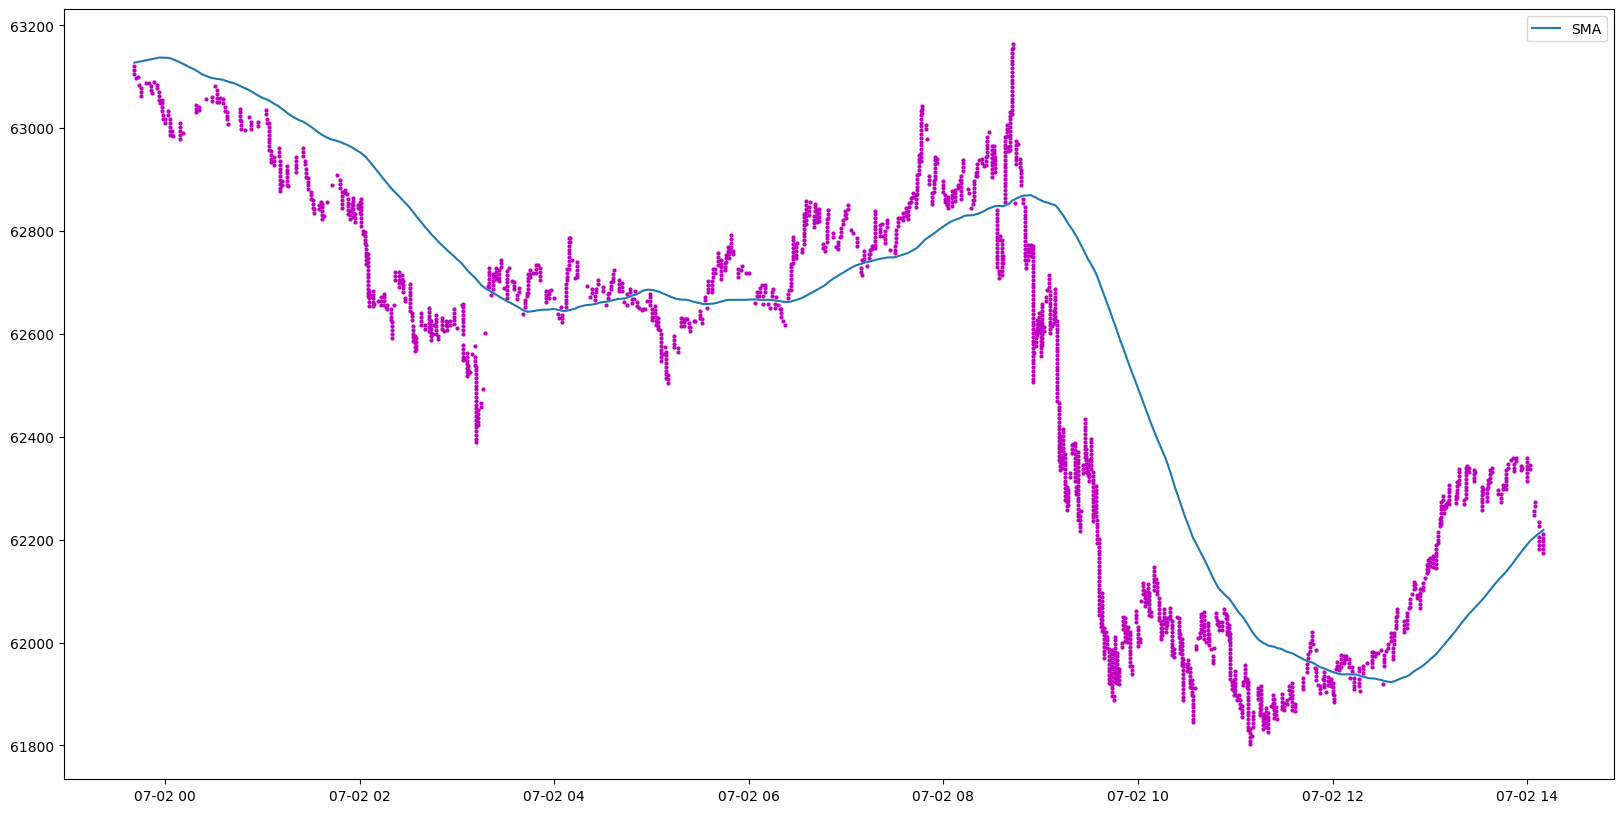

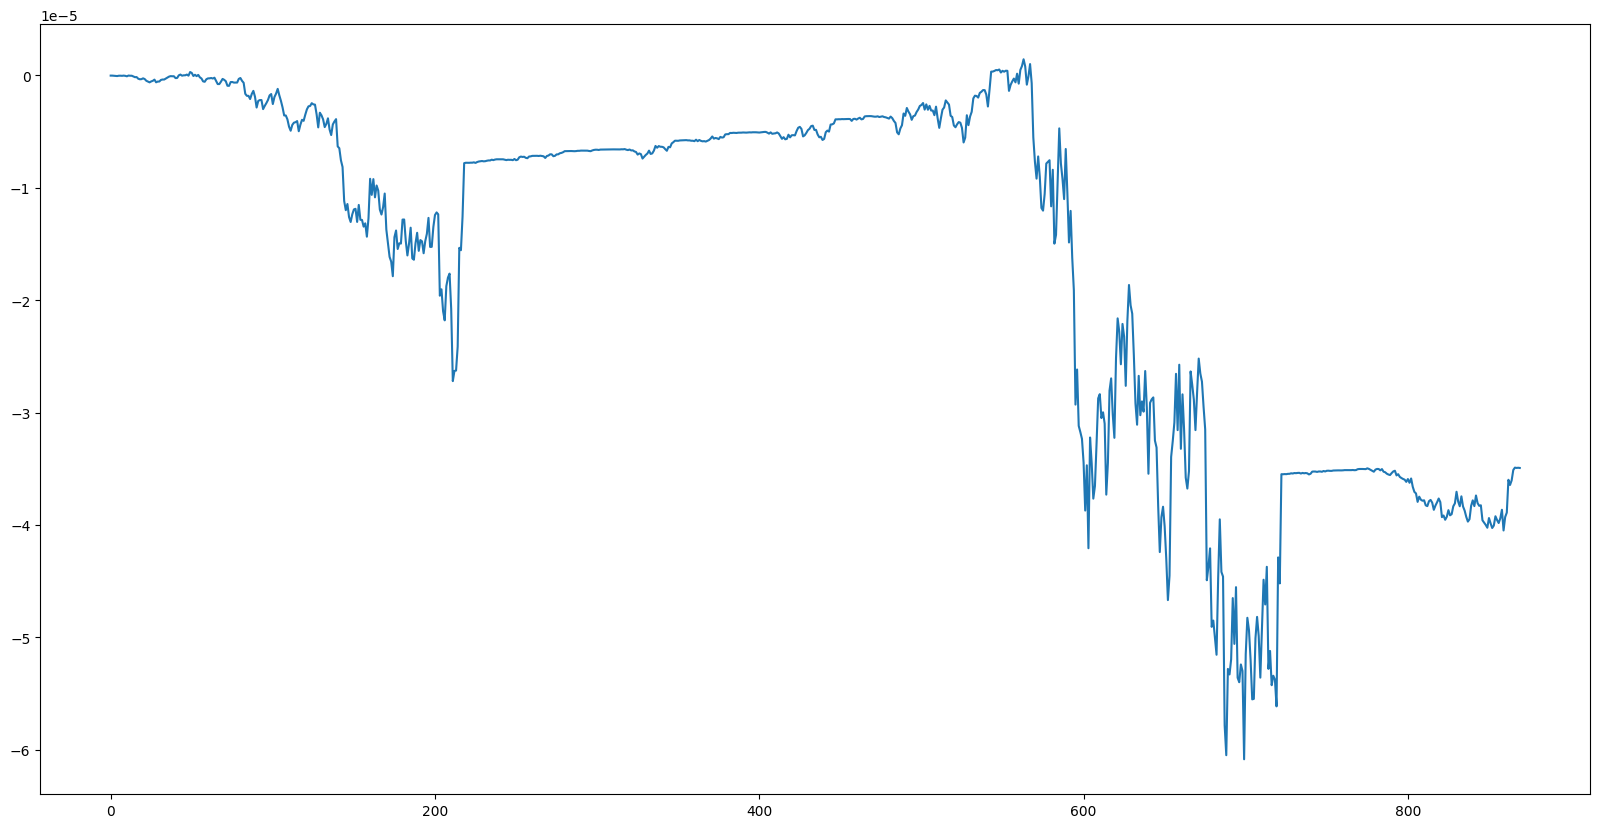

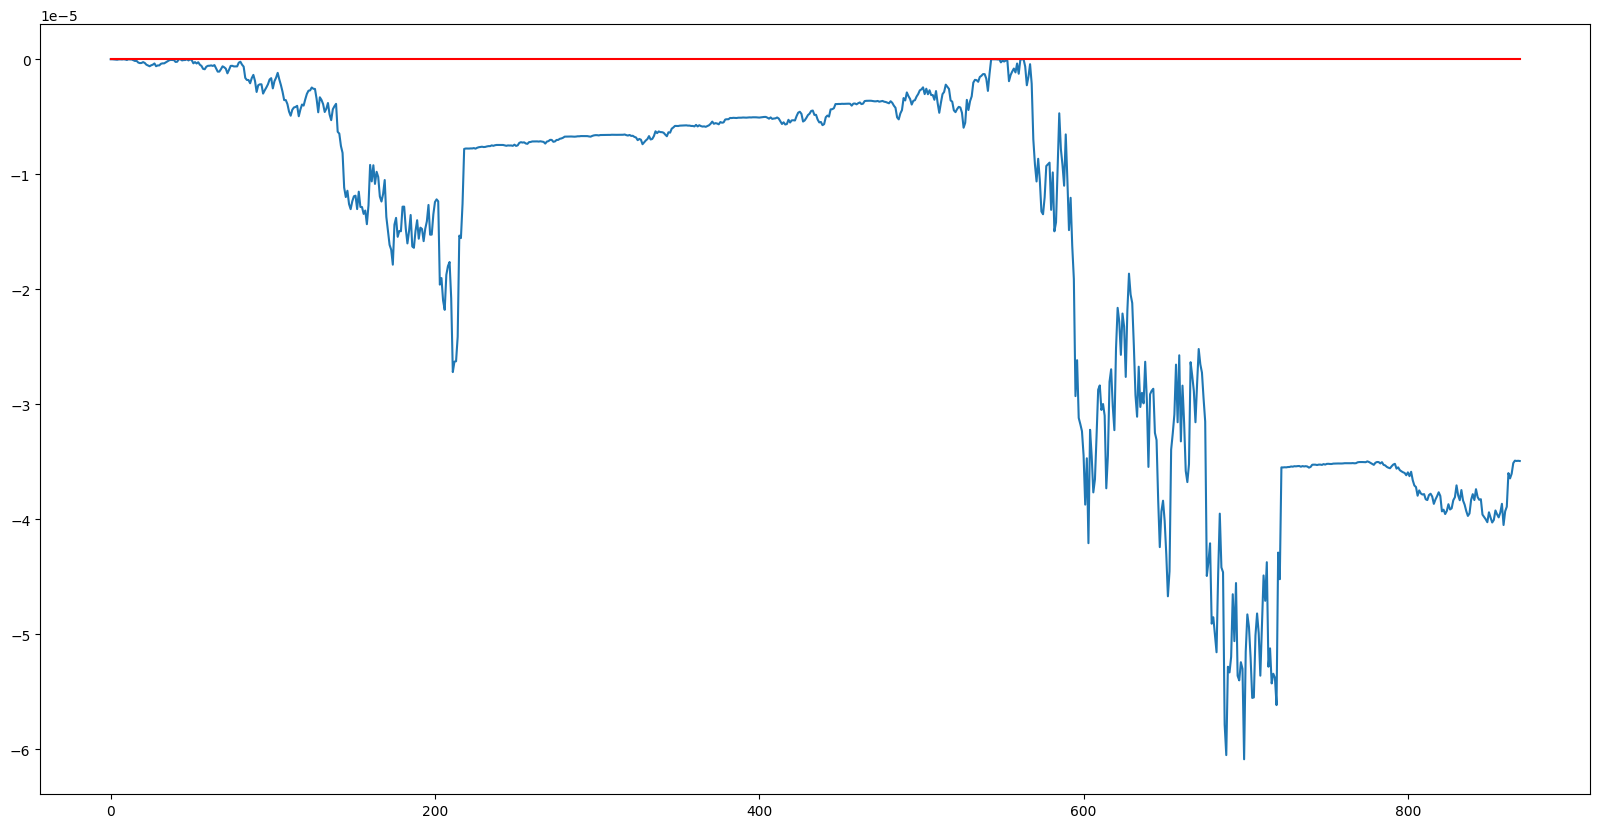

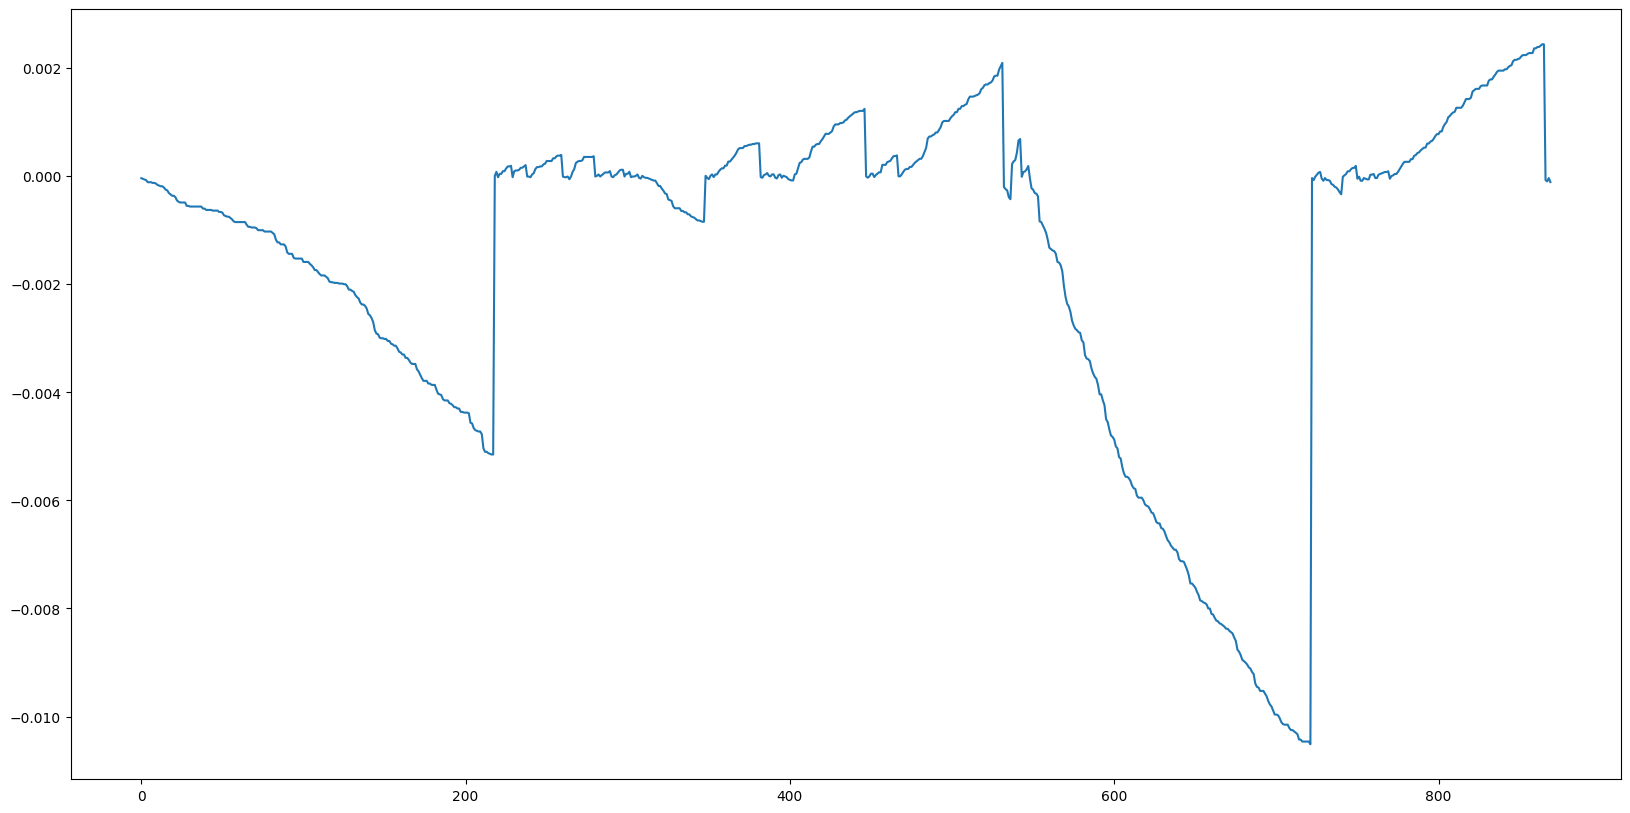

In [59]:
from numba import jit, njit, prange, vectorize, float64, int64, cuda, float32, guvectorize, void
from numba import float32, int32, int64, void, float64
from numba.typed import List
from numba.types import UniTuple

import numba as nb


nb_float = float64
nb_int = int64



class Backtest:
    def __init__(self, data, ma_lenth=100, num_grid=100, fee=-0.00015, pyrimading=1):
        
        
        self.pyramiding = pyrimading
        self.fee = fee
        self.num_grid = num_grid
        self.data = data
        
        self.decimal = len(str(data.iloc[0]['Close']).split('.')[1]) if '.' in str(data.iloc[0]['Close']) else 0
        
        self.data.loc[:, 'SMA'] = self.data['Close'].rolling(window=ma_lenth).mean().round(self.decimal)
        
        self.max_diff = ((self.data['SMA']-self.data['Close'])/self.data['SMA']).abs().max()
        
        stop_idx = self.data[(self.data['SMA'] < self.data['High']) & (self.data['SMA'] > self.data['Low'])].index[-1]

        self.data = self.data[:stop_idx].dropna()
        
        id = np.concatenate([np.arange(-self.num_grid, 0, 1, dtype=int), np.arange(1, self.num_grid+1, dtype=int)])
        self.orders = {
            'id': id,
            'open_price': -id * self.max_diff/self.num_grid,
            'close_price': np.zeros(self.num_grid*2),
            'direction': np.sign(id),
            }

        self.orders = pd.DataFrame(self.orders)
        
        self.amount = np.ones((self.num_grid*2, self.pyramiding), dtype=np.float64)/self.pyramiding
        
        self.amount = self.amount / self.amount.size

    @staticmethod
    # @njit([UniTuple(nb_float[:, :], 2)(nb_float[:, :], nb_float[:, :], nb_float, nb_float[:])], parallel=True, fastmath=True)
    @njit(parallel=False)
    def run_jit(data, orders, amount, fee):
        
        balance = np.zeros(len(data), dtype=np.float64)
        
        pos = np.zeros((len(data), len(orders)), dtype=np.float64)
        
        usdt_b = np.zeros(len(data), dtype=np.float64)
        
        normal_qty = 1 - fee
        
        for j in range(len(orders)):
            
            id, open_on, close_on, direction = orders[j]
            
            pyramiding = amount[j]
            
            num_positions = 0
            
            usdt = 0
            
            crypto = 0

            for i in range(len(data)):
                open, high, low, close, volume, sma = data[i]
                open_price = (open_on +1 ) * sma
                close_price = (close_on +1 ) * sma
                
                if i == 0:
                    if direction > 0:
                        if open < open_price:
                            num_positions += 1
                            crypto += amount[j, 0]/open_price
                            usdt -= normal_qty * pyramiding[0]
                            pos[i, j] = open_price
                            
                    else:
                        if open > open_price:
                            num_positions += 1
                            crypto -= amount[j, 0]/open_price
                            usdt += normal_qty * pyramiding[0]
                            pos[i, j] = open_price

                for k in range(num_positions + 1):
                    if k == num_positions:

                        if direction > 0:

                            if low < open_price and open > open_price and k < len(pyramiding) - 1:

                                num_positions += 1
                                crypto += pyramiding[k]/open_price
                                usdt -= normal_qty * pyramiding[k]
                                pos[i, j] = open_price

                        else:
                            if high > open_price and open < open_price and k < len(pyramiding) - 1:
                                num_positions += 1
                                crypto -= pyramiding[k]/open_price
                                usdt += normal_qty * pyramiding[k]
                                pos[i, j] = open_price
                    else:
                        if direction > 0:
                            if high > close_price and open < close_price:
                                num_positions = 0
                                usdt += normal_qty * crypto * close_price
                                crypto = 0

                        else:    
                            if low < close_price and open > close_price:
                                num_positions = 0
                                usdt += normal_qty * crypto * close_price
                                crypto = 0
                
                usdt_b[i] += usdt
                balance[i] += crypto * close + usdt
                              
        return balance, pos, usdt_b
    
    
    def run(self):
        
        # positions = self.run_jit(self.data.to_numpy(), self.orders.to_numpy())

        # self.positions = positions
        self.balance, self.pos, self.usdt_b = self.run_jit(self.data.to_numpy(), self.orders.to_numpy(), self.amount, self.fee)
        self.drawdown = self.cummax_diff(self.balance)

    @staticmethod
    @njit(parallel=True)
    def cummax_diff(A):
        B = np.zeros_like(A)
        max_val = A[0]
        for i in prange(len(A)):
            if A[i] < max_val:
                B[i] = A[i] - max_val
            else:
                max_val = A[i]
                B[i] = 0
        return B

    def test_jit(self):
    
        self.drawdown = self.portfolio.reshape(len(self.portfolio), -1).sum(axis=1)
        
    def plot(self):
        
        plt.figure(figsize=(20, 10))
        # plt.plot(self.data['Close'], label='Close')
        plt.plot(self.data['SMA'], label='SMA')
        # plt.plot(self.data['High'], label='High')   
        # plt.plot(self.data['Low'], label='Low')
        
        idx = np.where(self.pos != 0)
        plt.scatter(self.data.iloc[idx[0]].index, self.pos[idx], c='m', s=4)
        plt.legend()
        
        plt.show()
        
        plt.figure(figsize=(20, 10))
        plt.plot(self.balance, label='Portfolio')
        plt.show()
        plt.figure(figsize=(20, 10))
        plt.plot(self.drawdown, label='Drawdown')
        plt.plot(np.zeros(self.drawdown.shape[0]), c='r')
        plt.show()
        plt.figure(figsize=(20, 10))
        plt.plot(self.usdt_b, label='USDT balance')
        plt.show()

bt = Backtest(data, pyrimading=20)

bt.run()
bt.plot() 

In [61]:
%timeit -n 10 -r 7 bt.run()

The slowest run took 78.16 times longer than the fastest. This could mean that an intermediate result is being cached.
52 ms ± 29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
